# Assessing the validity of industry end use demand data for use in Euro-calliope to describe Industry demand in each country (space heating, water heating, process heating, and all other demand)

In [10]:
import sys
import os

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append('../src/construct/')
import util

idx = pd.IndexSlice

in_data_path = '/Users/brynmorp/Data/'
out_data_path = '../data/'

In [45]:
# Extract Austrian data
def get_at_end_use_df(year=None, region=None):
    files = {
        'AT': '066288',  # NUTS0
        'AT11': '066289',  # NUTS2
        'AT12': '066291',  # NUTS2
        'AT13': '066297',  # NUTS2
        'AT21': '066290',  # NUTS2
        'AT22': '066294',  # NUTS2
        'AT31': '066292',  # NUTS2
        'AT32': '066293',  # NUTS2
        'AT33': '066295',  # NUTS2
        'AT34': '066296'  # NUTS2
    }
    if region is not None:
        files = {region: files[region]}
    if year is not None:
        years = [year]
    else:
        years = range(2005, 2018)
    end_uses = []
    
    for region, filecode in files.items():
        for year in years:
            _end_use_demand = pd.read_excel(
                f'https://www.statistik.at/wcm/idc/idcplg?IdcService=GET_NATIVE_FILE&RevisionSelectionMethod=LatestReleased&dDocName={filecode}', 
                sheet_name=f'NEA {year}', usecols="U:AI", skiprows=30, header=None
            ).dropna()
            table_ends = _end_use_demand[_end_use_demand[20] == 'Peat'].index
            dfs = []

            for i in range(0, len(table_ends)):
                if i == 0:
                    _df = _end_use_demand.loc[:table_ends[i] + 1]
                else:
                    _df = _end_use_demand.loc[table_ends[i - 1] + 1:table_ends[i] + 1]

                _df = _df.set_index(20).drop(['Shares', 'TOTAL', 0], errors='ignore')
                _df.columns = _df.iloc[0].values
                _df.rename(
                    columns={'Indust. furnaces': 'Industrial furnaces',
                            'of which electochemical purp.': 'of which electochemical purposes'}, 
                    inplace=True
                )
                _df.index.set_names('carrier_name', inplace=True)
                _df = _df.assign(cat_name=_df.iloc[0].name)
                _df = _df.drop(_df.iloc[0].name).drop(['Other', 'Total'], axis=1)
                _df.columns = (
                    _df.columns
                    .str.lower()
                    .str.replace("of which ", "")
                    .str.replace(" & ", "_")
                    .str.replace(" ", "_")
                )
                _df = _df.set_index('cat_name', append=True)

                dfs.append(_df)
            end_uses.append(
                pd.concat(dfs, sort=True)
                .sort_index()
                .assign(region=region, year=year, unit='TJ')
                .set_index(['region', 'year', 'unit'], append=True)
            )
    return pd.concat(end_uses, sort=True)

In [6]:
# Extract German industry data (file comes from contact in ISI Fraunhofer)
def get_de_end_use_df():
    dfs = []
    for year in range(2013, 2019):
        sheet = pd.read_excel(
            in_data_path + '/Germany/Drucktabellen Anwendungsbilanzen 2013-2018.xlsx', sheet_name=f'IND_{year}'
        )
        table_ends = sheet[sheet['Unnamed: 0'] == 'Summe'].index
        table_ends = table_ends.insert(0, 1)
        for i in range(0, len(table_ends) - 1):
            _df = sheet.iloc[table_ends[i] + 1:table_ends[i + 1] + 1].dropna(how='all').dropna(how='all', axis=1)
            _subsector = _df.iloc[0, 0]
            _cols = _df.iloc[1].dropna().values
            _idx = _df.dropna().iloc[:, 0]
            if _subsector.startswith('Strom'):
                _cols_lim = list(_cols).index('Summe')
                _df = _df.dropna().set_index('Unnamed: 0').rename_axis(index='cat_name')
                _df = _df.assign(carrier_name=_subsector).set_index('carrier_name', append=True)
                _df = _df.iloc[:, :_cols_lim]
                _df.columns = _cols[:_cols_lim]
            else:
                _df = _df.dropna().set_index('Unnamed: 0').rename_axis(index='carrier_name')
                _df = _df.assign(cat_name=_subsector).set_index('cat_name', append=True)
                _df.columns = _cols

            _df.rename_axis(columns='end_use', inplace=True)
            _df = _df.drop('Summe', axis=0, errors='ignore').drop('Summe', axis=1, errors='ignore')
            _df = _df.assign(year=year).set_index('year', append=True)
            _df = _df.assign(unit='PJ').set_index('unit', append=True)
            dfs.append(_df.stack().reorder_levels(['cat_name', 'carrier_name', 'end_use', 'year', 'unit']))
    return pd.concat(dfs)

In [7]:
# Extract UK industry data
def get_uk_end_use_df():
    sheet = pd.read_excel(
        'https://www.gov.uk/government/uploads/system/uploads/attachment_data/file/820752/2019_End_use_tables.xlsx', 
        sheet_name='Table U4', skiprows=4
    )
    dfs = []
    table_ends = sheet[sheet['Unnamed: 3'] == 'Total industries'].index
    table_ends = table_ends.insert(0, 0)
    carriers = sheet.iloc[0, :]
    for i in range(0, len(table_ends) - 1):
        _df = sheet.iloc[table_ends[i] + 1:table_ends[i + 1] + 1].dropna(how='all').dropna(how='all', axis=1)

        year = _df.iloc[0, 0]
        _cols = carriers.dropna().reset_index()
        _cols['end_use'] = _cols['index'].where(_cols['index'].str.find('Unnamed') == -1).bfill()
        _cols = _cols.set_index([0, 'end_use']).index

        _df = _df[_df['Unnamed: 3'].str.find('Total') > -1].set_index('Unnamed: 3').dropna(axis=1)
        _df.index = _df.index.str.replace('Total ', '').rename('cat_name')
        _df = _df.assign(year=year).set_index('year', append=True)
        _df = _df.assign(unit='ktoe').set_index('unit', append=True)
        _df.columns = _cols
        _df = _df.drop('Total', axis=1, level=0).drop('Total ', axis=1, level=1)

        _df.rename_axis(columns=['carrier_name', 'end_use'], inplace=True)

        dfs.append(_df.stack([0, 1]).reorder_levels(['cat_name', 'carrier_name', 'end_use', 'year', 'unit']))
    return pd.concat(dfs)

In [8]:
# Mapping of categories to normalise each dataset
DE_subsectors = {
    'Gew. v. Steinen u. Erden': 'Mining & quarrying',
    'Ernährung und Tabak': 'Food, beverages & tobacco',
    'Papiergewerbe': 'Paper, pulp & printing',
    'Grundstoffchemie': 'Chemical & petrochemical',
    'Sonst. chemische Industrie': 'Chemical & petrochemical',
    'Gummi- u. Kunststoffwaren': 'Not elsewhere specified (industry)',
    'Glas u. Keramik': 'Non-metallic minerals',
    'Verarb. v. Steine u. Erden': 'Non-metallic minerals',
    'Metallerzeugung ': 'Metals',
    'NE-Metalle, -gießereien': 'Metals',
    'Metallbearbeitung': 'Metals',
    'Maschinenbau': 'Machinery',
    'Fahrzeugbau': 'Transport equipment',
    'Sonst. Verarbeitendes Gewerbe': 'Not elsewhere specified (industry)',
}
DE_end_uses = {
    'Beleuchtung': 'end_use_electricity',
    'Elektrische Antriebe (Druckluft)': 'mechanical',
    'Elektrische Antriebe (Pumpen)': 'mechanical',
    'Sonstige Mechanische Energie': 'mechanical',
    'IKT': 'end_use_electricity',
    'Klimakälte': 'space_cooling',
    'Prozesskälte': 'process_cooling',
    'Prozesswärme': 'process_heating',
    'Raumwärme': 'space_heating',
    'Warmwasser': 'water_heating'
}
DE_carriers = {
    'Erneuerbare': 'renewable_heat',
    'Fernwärme': 'district_heat',
    'Heizöl (Leicht)': 'oil',
    'Heizöl (Schwer)': 'oil',
    'Kohlen': 'solid_fuel',
    'Naturgase': 'natural_gas',
    'Sonstige Brennstoffe': 'other',
    'Sonstige Gase': 'manufactured_gas',
    'Sonstige Mineralöle': 'oil',
    'Strom (f. Anhang)': 'electricity',
}

UK_subsectors = {
    'Iron, steel, non ferrous metals': 'Metals',
    'chemicals':  'Chemical & petrochemical',
    'electrcial engineering': 'Machinery',
    'food, drink and tobacco': 'Food, beverages & tobacco',
    'mechanical engineering': 'Machinery',
    'mineral products': 'Non-metallic minerals',
    'other industries': 'Not elsewhere specified (industry)',
    'printing, publishing': 'Paper, pulp & printing',
    'textiles, leather, etc': 'Textile & leather',
    'vehicles': 'Transport equipment'
}
UK_end_uses = {
    'Compressed Air': 'mechanical', 
    'Drying / Separation': 'process_heating', 
    'High temperature process': 'process_heating', 
    'Lighting': 'end_use_electricity', 
    'Low Temperature Process': 'process_heating', 
    'Motors': 'mechanical', 
    'Other': 'other', 
    'Refrigeration': 'process_cooling', 
    'Space Heating': 'space_heating'
}
UK_carriers = {
    'Electricity': 'electricity', 
    'Natural Gas': 'natural_gas', 
    'Oil': 'oil', 
    'Solid Fuel': 'solid_fuel'
}

AT_carriers = {
    'Ambient and solar heat': 'renewable_heat', # 'Renewable heat',
    'Biofuels': 'solid_fuel', # 'Primary solid biofuels',
    'Blast furnace gas': 'manufactured_gas', # 'Manufactured gas',
    'Coke oven coke': 'solid_fuel', # 'Solid fossil fuels',
    'Coke oven gas': 'manufactured_gas', # 'Manufactured gas',
    'Diesel': 'oil', # 'Oil and petroleum products',
    'District heat': 'district_heat', # 'District heat',
    'Electricity': 'electricity', # 'Electricity',
    'Fuel oil': 'oil', # 'Oil and petroleum products',
    'Fuel wood': 'solid_fuel', # 'Primary solid biofuels',
    'Gas oil': 'oil', # 'Oil and petroleum products',
    'Gasoline': 'oil', # 'Oil and petroleum products',
    'Hard coal': 'solid_fuel', # 'Solid fossil fuels',
    'Kerosene': 'oil', # 'Oil and petroleum products',
    'LPG': 'oil', # 'Oil and petroleum products',
    'Lignite': 'solid_fuel', # 'Solid fossil fuels',
    'Natural gas': 'natural_gas', # 'Natural gas',
    'Other energy sources': 'other', # 'Other',
    'Peat': 'solid_fuel', # 'Peat',
    'Petrol coke': 'oil', # 'Oil and petroleum products',
    'Waste': 'waste', # 'Waste'
}
AT_end_uses = {
    'air_condition': 'space_cooling',
    'cooling': 'process_cooling',
    'drying': 'process_heating',
    'electochemical_purposes': 'end_use_electricity',
    'industrial_furnaces': 'process_heating',
    'lightning_computing': 'end_use_electricity',
    'other': 'other',
    'space_heating': 'space_heating'  ,
    'stationary_engines': 'mechanical',
    'traction': 'mechanical',
    'vapor_production': 'process_heating',
    'water_heating': 'water_heating'
}
AT_subsectors = {
    'Chemical and petrochemical industry': 'Chemical & petrochemical',
    'Construction': 'Construction',
    'Food, tabacco and beverages': 'Food, beverages & tobacco',
    'Iron and steel': 'Metals',
    'Machinery': 'Machinery',
    'Mining and quarrying': 'Mining & quarrying',
    'Non ferrous metals': 'Metals',
    'Non metalic minerals': 'Non-metallic minerals',
    'Non specified industry': 'Not elsewhere specified (industry)',
    'Paper, pulp and print': 'Paper, pulp & printing',
    'Textiles and leather': 'Textile & leather',
    'Transport equipment': 'Transport equipment',
    'Wood and wood products': 'Wood & wood products'
}

In [14]:
# Normalise all the data and save to file
if 'industry_end_use_consumption_published.csv' not in os.listdir(out_data_path):
    at_end_use_tdf = (
        get_at_end_use_df()
        .xs(('TJ', 'AT'), level=('unit', 'region'))
        .apply(util.tj_to_twh)
        .stack()
        .unstack('year')
        .groupby([AT_carriers, AT_subsectors, AT_end_uses], level=[0, 1, 2]).sum()
        .stack()
        .rename_axis(index=['carrier_name', 'cat_name', 'end_use', 'year'])
        .reorder_levels(['cat_name', 'carrier_name', 'end_use', 'year'])
    )
    de_end_use_tdf = (
        get_de_end_use_df()
        .xs(('PJ'), level=('unit'))
        .apply(util.pj_to_twh)
        .unstack('year')
        .groupby([DE_subsectors, DE_carriers, DE_end_uses], level=[0, 1, 2]).sum()
        .stack()
    )
    uk_end_use_tdf = (
        get_uk_end_use_df()
        .xs(('ktoe'), level=('unit'))
        .apply(util.ktoe_to_twh)
        .unstack('year')
        .groupby([UK_subsectors, UK_carriers, UK_end_uses], level=[0, 1, 2]).sum()
        .stack()
    )
    end_use_tdf = pd.concat([at_end_use_tdf, de_end_use_tdf, uk_end_use_tdf], keys=['AT', 'DE', 'UK'], names=['country_code'])
    end_use_tdf = end_use_tdf.where(end_use_tdf > 0).dropna()
    end_use_tdf.to_csv(out_data_path + '/industry_end_use_consumption_published.csv')
else:
    end_use_tdf = pd.read_csv(out_data_path + '/industry_end_use_consumption_published.csv', index_col=[0, 1, 2, 3, 4], squeeze=True)

In [16]:
# Go from consumption to demand, assuming some efficiencies for the consumption of different fuels
end_use_demand = (
    end_use_tdf.mul(pd.Series({
        'district_heat': 1, 
        'electricity': 1, 
        'manufactured_gas': 0.95, 
        'natural_gas': 0.95,
        'oil': 0.9,
        'other': 1, 
        'renewable_heat': 1, 
        'solid_fuel': 0.9, 
        'waste': 0.8
    }), level='carrier_name')
    .sum(level=['country_code', 'cat_name', 'end_use', 'year'])
)
end_use_demand_percent = end_use_demand.div(end_use_demand.sum(level=['country_code', 'cat_name', 'year']))

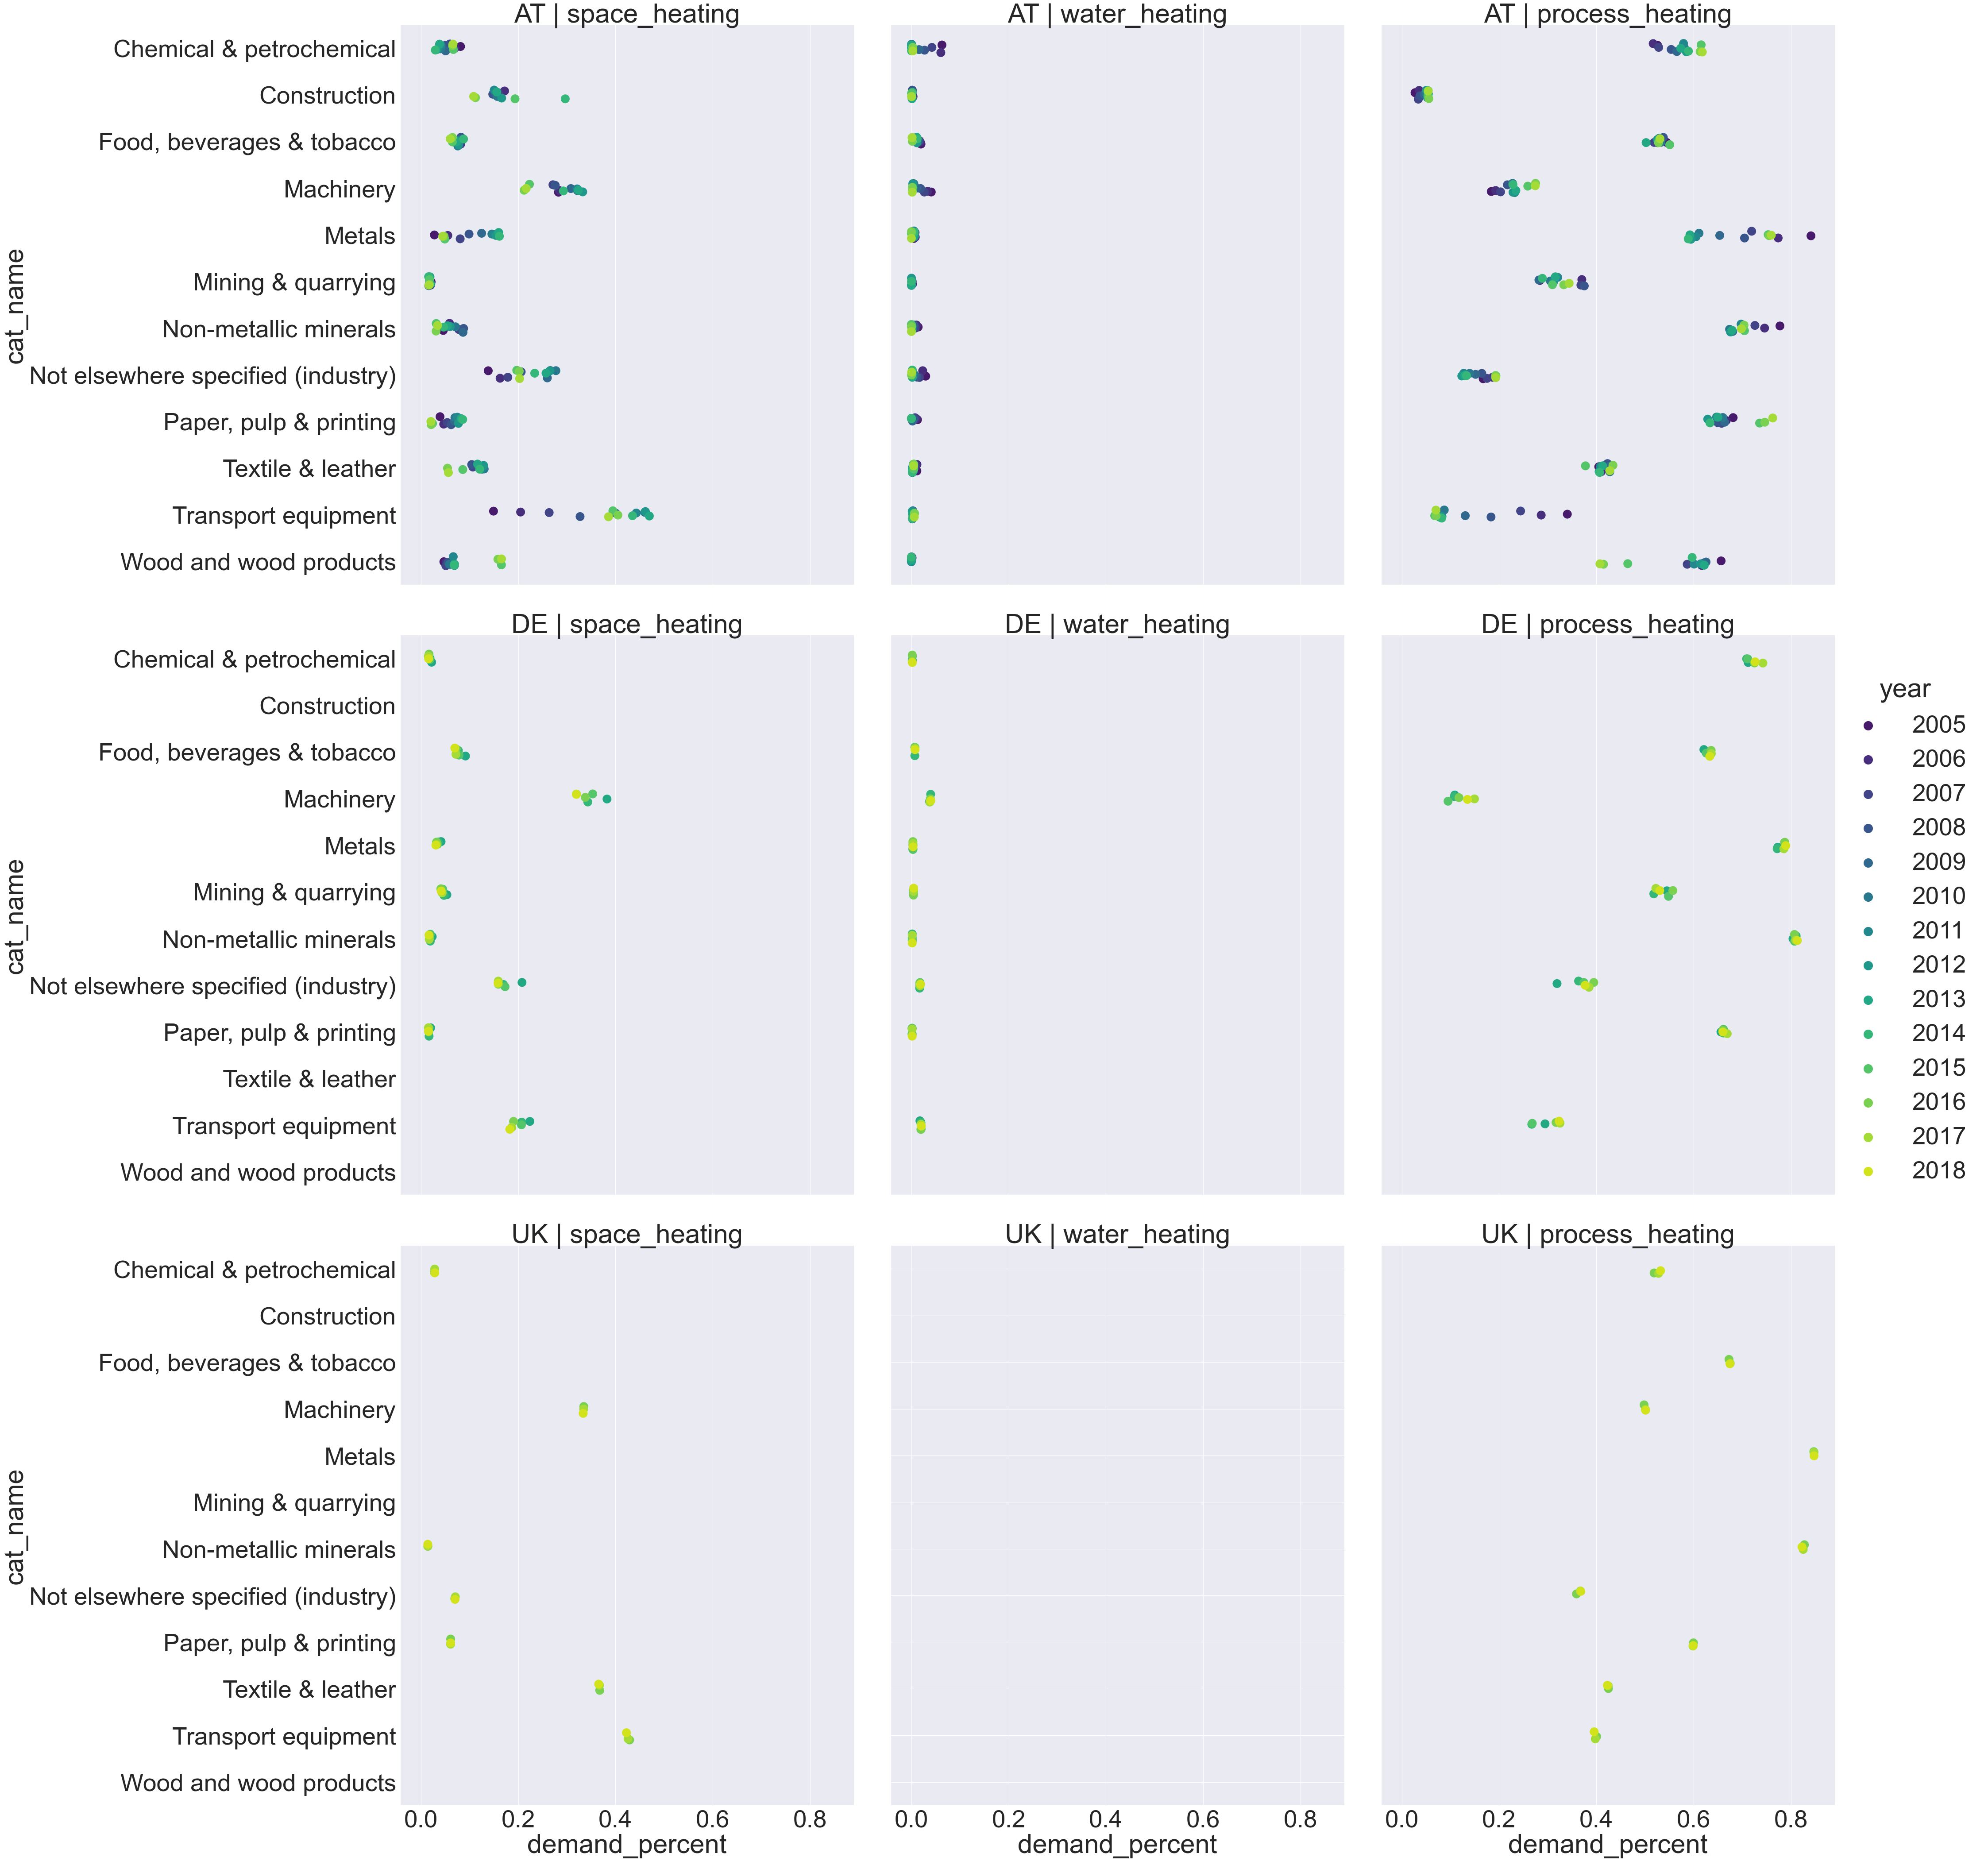

In [880]:
# Plot percentage contribution of heating end uses to total demand for each year, country, and industry subsector
with sns.plotting_context("notebook", font_scale=5):
    g = sns.catplot(
        data=end_use_demand_percent.filter(regex='heating', axis=0).to_frame('demand_percent').reset_index(), 
        y='cat_name', x='demand_percent', col="end_use", row='country_code', hue="year",
        hue_order=[i for i in range(2005, 2019)], palette='viridis', legend=True, 
        height=20, aspect=1, s=20
    )
    g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
    for i in g._legend.legendHandles:
        i._sizes = [400]
    g._legend.set_title('year', prop={'size': 60})

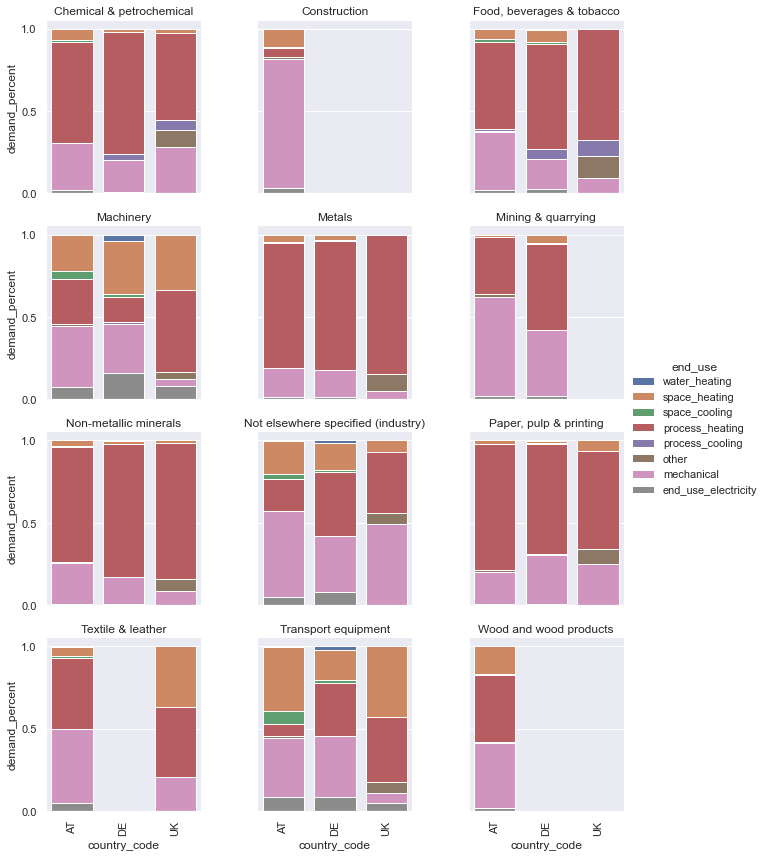

In [862]:
# Plot percentage contribution of different processes to total energy demand in each industry subsector
# In 2017 for each country seperately
with sns.plotting_context("notebook", font_scale=1):
    g = sns.FacetGrid(
        end_use_demand_percent
        .xs(2017, level='year')
        .unstack(['country_code', 'cat_name'])
        .cumsum() # proxy for a stacked bar
        .stack([0, 1])
        .to_frame('demand_percent')
        .reset_index(), 
        col="cat_name", 
        hue="end_use", 
        hue_order=list(reversed(['end_use_electricity', 'mechanical', 'other', 'process_cooling',
           'process_heating', 'space_cooling', 'space_heating', 'water_heating'])), 
        col_wrap=3
    )
    g.map(
        sns.barplot, 'country_code', 'demand_percent', order=['AT', 'DE', 'UK']
    )
    g.add_legend()
    g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
foo = [plt.setp(ax.get_xticklabels(), rotation=90) for ax in g.axes.flat]

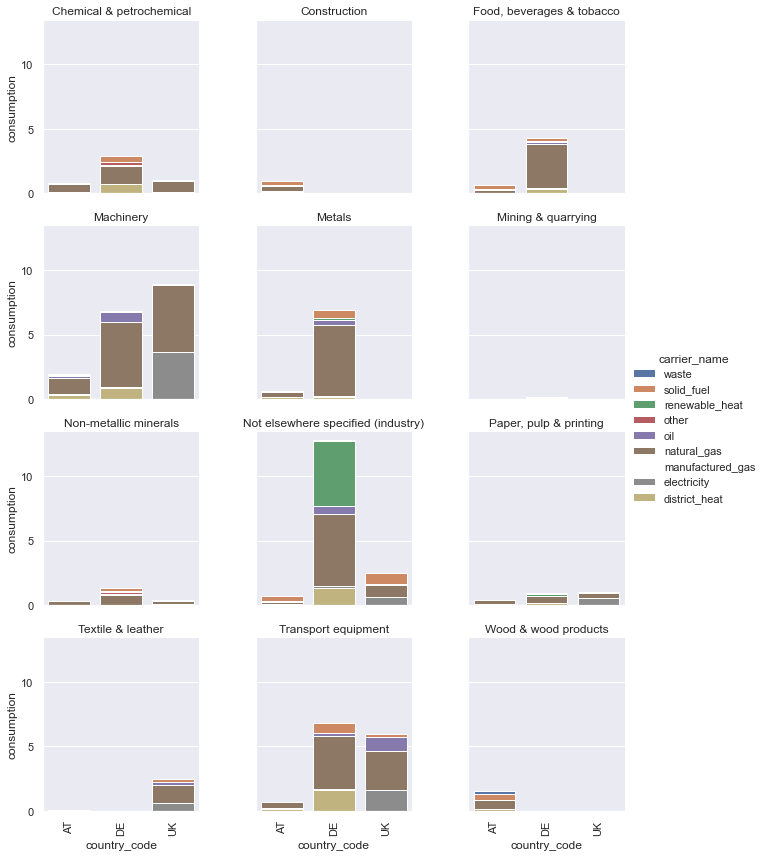

In [1043]:
# Plot percentage contribution of different processes to total energy demand in each industry subsector
# In 2017 for each country seperately
with sns.plotting_context("notebook", font_scale=1):
    g = sns.FacetGrid(
        end_use_tdf
        .xs(('space_heating', 2016), level=('end_use', 'year'))
        .unstack(['country_code', 'cat_name'])
        .cumsum() # proxy for a stacked bar
        .stack([0, 1])
        .to_frame('consumption')
        .reset_index(), 
        col="cat_name", 
        hue="carrier_name",  
        hue_order=end_use_tdf.index.get_level_values('carrier_name').unique()[::-1],
        col_wrap=3
    )
    g.map(
        sns.barplot, 'country_code', 'consumption', order=['AT', 'DE', 'UK']
    )
    g.add_legend()
    g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
foo = [plt.setp(ax.get_xticklabels(), rotation=90) for ax in g.axes.flat]

# Compare Autria published stats for 2012 and the FORECAST-Industry model data for the same year

In [841]:
forecast = pd.read_csv(out_data_path + '/industry_heat_demand.csv', index_col=[0, 1, 2], header=0)
forecast_at = (
    forecast
    .xs('Austria', level='country_name')
    .unstack(1).groupby({
        'District heating': 'District heating', 
        'Electricity': 'Electricity', 
        'Other fossil': 'Other fossil', 
        'Natural gas': 'Natural gas',
        'Fuel oil': 'Fuel oil',
        'other': 'other', 
        'Solar energy': 'Ambient and solar heat', 
        'Ambient heat': 'Ambient and solar heat', 
        'Geothermal': 'Geothermal', 
        'Coal': 'Coal', 
        'Biomass': 'Biomass', 
        'Waste RES': 'Waste',
        'Waste non-RES': 'Waste',
        'Other RES': 'other'
    }).sum()
    .T
)

forecast_at_sh = forecast_at.xs('space_heating')
forecast_at_ph = forecast_at.drop('space_heating', level=0).sum(level='cat_name')

at_compare_with_forecast = (
    get_at_end_use_df()
    .xs(('AT', 2012, 'PJ'), level=('region', 'year', 'unit'))
    .unstack('carrier_name')
    .drop('MANUFACTURING INDUSTRIES IN TOTAL')
    .apply(tj_to_twh)
    .groupby({
        'Chemical and petrochemical industry': 'Chemical and Petrochemical',
        'Construction': 'Other Industry',
        'Food, tabacco and beverages': 'Food, Beverages and Tabacco',
        'Iron and steel': 'Iron and Steel',
        'Machinery': 'Machinery and transport',
        'Mining and quarrying': 'Other Industry',
        'Non ferrous metals': 'Non-ferrous metals',
        'Non metalic minerals': 'Non-metallic minerals',
        'Non specified industry': 'Other Industry',
        'Paper, pulp and print': 'Paper, Pulp and Printing',
        'Textiles and leather': 'Other Industry',
        'Transport equipment': 'Machinery and transport',
        'Wood and wood products': 'Other Industry'
    }).sum()
    .reindex(forecast_at_sh.index)
    .stack(1).unstack(0)
    .groupby({
        'Ambient and solar heat': 'Ambient and solar heat',
        'Biofuels': 'Biomass',
        'Blast furnace gas': 'Other fossil',
        'Coke oven coke': 'Other fossil',
        'Coke oven gas': 'Other fossil',
        'Diesel': 'Other fossil',
        'District heat': 'District heating',
        'Electricity': 'Electricity',
        'Fuel oil': 'Fuel oil',
        'Fuel wood': 'Biomass',
        'Gas oil': 'Other fossil',
        'Gasoline': 'Other fossil',
        'Hard coal': 'Coal',
        'Kerosene': 'Other fossil',
        'LPG': 'Other fossil',
        'Lignite': 'Coal',
        'Natural gas': 'Natural gas',
        'Other energy sources': 'other',
        'Peat': 'other',
        'Petrol coke': 'Other fossil',
        'Waste': 'Waste'
    }).sum()
    .reindex(forecast_at_sh.columns)
    .T
)


at_compare_with_forecast_sh = at_compare_with_forecast.xs('space_heating')
at_compare_with_forecast_ph = at_compare_with_forecast.loc[
    (['drying', 'industrial_furnaces', 'vapor_production', 'water_heating'], ), :
].sum(level='cat_name')

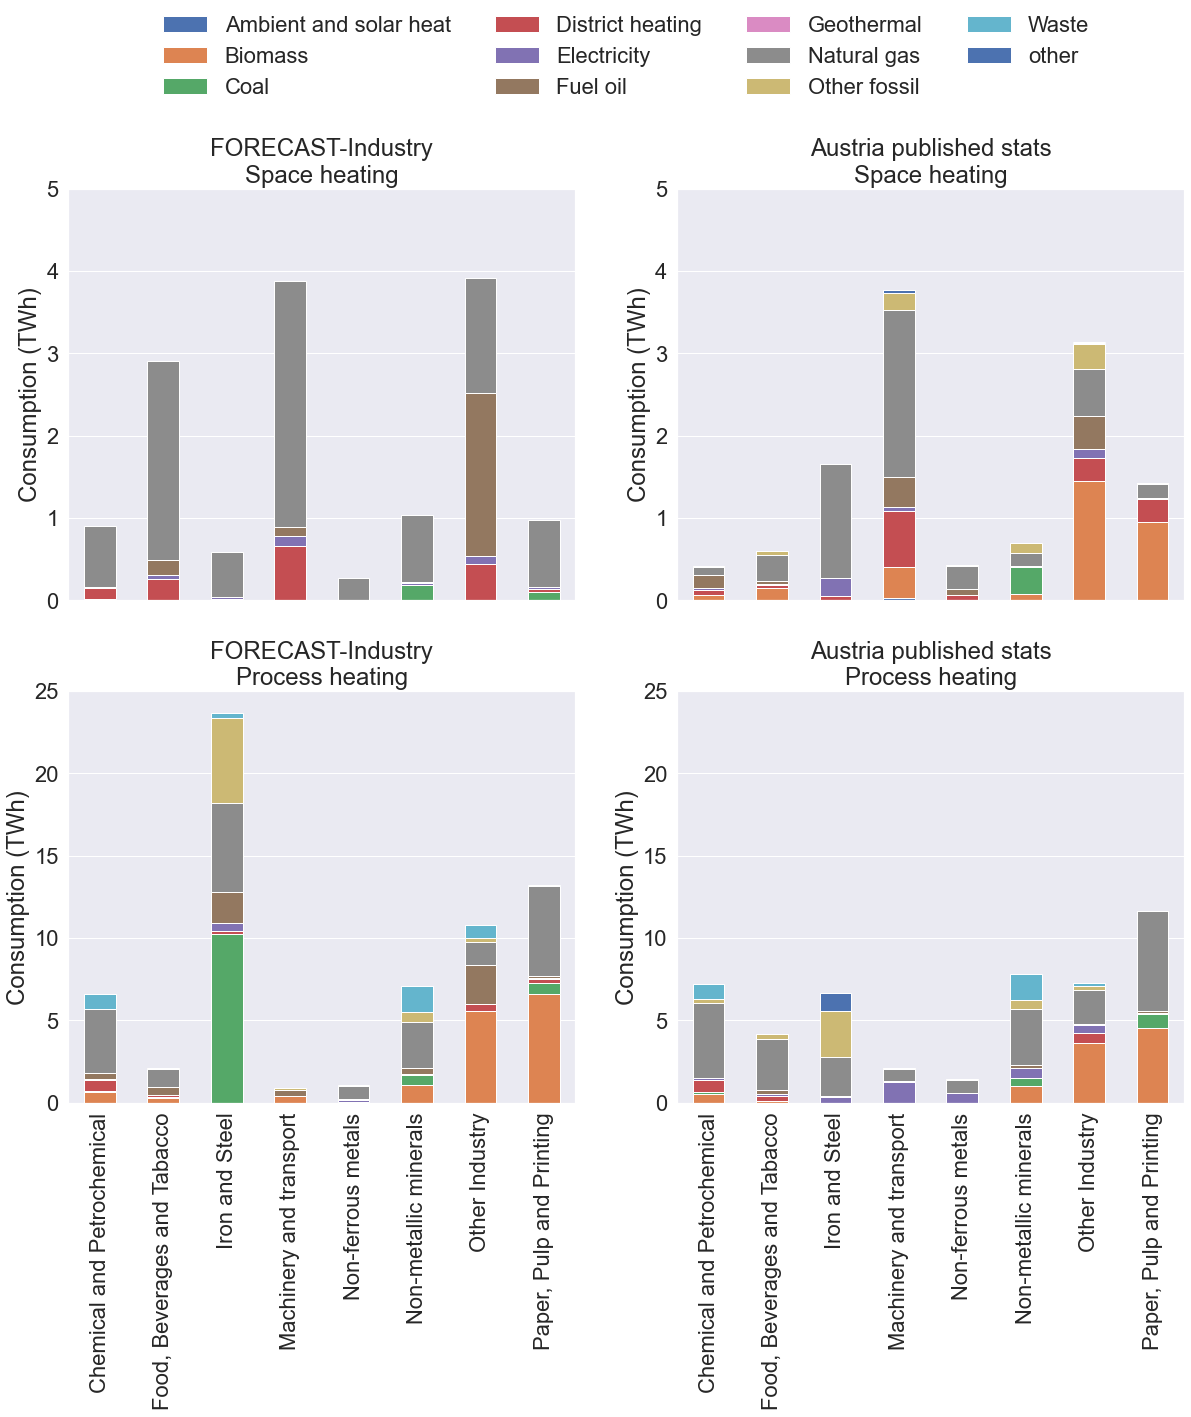

In [857]:
fig = plt.figure(figsize=(20, 20))
g = plt.GridSpec(3, 2, figure=fig, height_ratios=(2, 10, 10), hspace=0.3)
ax1 = fig.add_subplot(g[1, 0])
ax2 = fig.add_subplot(g[1, 1])
ax3 = fig.add_subplot(g[2, 0])
ax4 = fig.add_subplot(g[2, 1])
cax = fig.add_subplot(g[0, :])

forecast_at_sh.plot.bar(
    ax=ax1, stacked=True, title='FORECAST-Industry\nSpace heating'
)
at_compare_with_forecast_sh.plot.bar(
    ax=ax2, stacked=True, legend=False, title='Austria published stats\nSpace heating'
)
handles, labels = ax1.get_legend_handles_labels()
ax1.get_legend().remove()

for i in [ax1, ax2]:
    i.set_ylim(0, 5)
    i.set_ylabel('Consumption (TWh)')
    i.xaxis.set_visible(False)
    
forecast_at_ph.plot.bar(
    ax=ax3, stacked=True, legend=False, title='FORECAST-Industry\nProcess heating'
)
at_compare_with_forecast_ph.plot.bar(
    ax=ax4, stacked=True, legend=False, title='Austria published stats\nProcess heating'
)
handles, labels = ax1.get_legend_handles_labels()
for i in [ax3, ax4]:
    i.set_ylim(0, 25)
    i.set_xlabel('')
    i.set_ylabel('Consumption (TWh)')
    i.grid(b=None, axis='x')

cax.axis('off')
cax.legend(handles=handles, labels=labels, ncol=4, loc='center', frameon=False)

# Compare to HeatRoadmap Europe, which uses FORECAST-Industry with data from the year 2015

In [63]:
at_end_use_df = get_at_end_use_df(year=2015, region='AT')
at_end_use_df = at_end_use_df.apply(util.tj_to_twh).reset_index(['region', 'year', 'unit'], drop=True).xs('MANUFACTURING INDUSTRIES IN TOTAL', level='cat_name')

at_end_use_df_for_comparison = at_end_use_df.groupby({
    'Ambient and solar heat': 'ambient_solar_thermal', 
    'Biofuels': 'biofuel', 
    'Blast furnace gas': 'gas', 
    'Coke oven coke': 'solid_fuel', 
    'Coke oven gas': 'gas', 
    'Diesel': 'oil', 
    'District heat': 'district_heat', 
    'Electricity': 'electricity', 
    'Fuel oil': 'oil', 
    'Fuel wood': 'biofuel', 
    'Gas oil': 'oil', 
    'Gasoline': 'oil', 
    'Hard coal': 'solid_fuel', 
    'Kerosene': 'oil', 
    'LPG': 'oil', 
    'Lignite': 'solid_fuel', 
    'Natural gas': 'gas', 
    'Other energy sources': 'other', 
    'Peat': 'other', 
    'Petrol coke': 'oil', 
    'Waste': 'other', 
}).sum().groupby(AT_end_uses, axis=1).sum()[['space_heating', 'process_heating']]

In [100]:
HRE_df = pd.read_excel('https://heatroadmap.eu/wp-content/uploads/2018/09/HRE4-Exchange-Template-WP3_v22b_website.xlsx', sheet_name='Industry data', skiprows=4, index_col=[0, 1, 2, 3 , 4, 5], usecols="N:S,X:AB")
HRE_df.columns = HRE_df.values[2]
HRE_df = (
    HRE_df
    .rename_axis(index=HRE_df.index[2]).iloc[3:]
    .reset_index(['Country group', 'Sector', 'Subsector'], drop=True)
)
HRE_df = (
    HRE_df
    .set_index(
        HRE_df
        .index
        .get_level_values('Country')
        .map(util.get_alpha2)
        .rename('country_code'), 
        append=True
    )
    .reset_index(['Country', 'Year'], drop=True)
    .apply(util.to_numeric)
    .dropna(how='all')
)

HRE_at_df = HRE_df.xs('AT', level='country_code').groupby([
    {'Biomass': 'biofuel',
    'Coal': 'solid_fuel',
    'Compression cooling (electricity)': 'electricity',
    'District heating': 'district_heat',
    'Electric Heating': 'direct_electric',
    'Gas': 'gas',
    'Heat pumps total (electric)': 'heat_pump_electric',
    'Micro CHP (biomass)': 'biofuel',
    'Micro CHP (natural gas)': 'gas',
    'Oil': 'oil',
    'Others (RES)': 'other',
    'Others (fossil)': 'other',
    'Solar thermal': 'ambient_solar_thermal'},
]).sum().groupby(
    {'PH <100 (FED)': 'process_heating',
    'PH 100-200 (FED)': 'process_heating',
    'PH 200-500 (FED)': 'process_heating',
    'PH >500 (FED)': 'process_heating',
    'SH (FED)': 'space_heating'},
    axis=1
).sum()

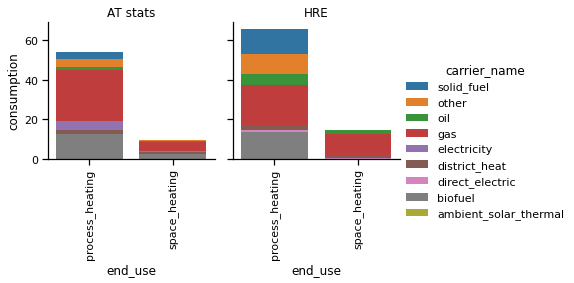

In [101]:
HRE_comparison_df = pd.concat([HRE_at_df, at_end_use_df_for_comparison], names=['source'], keys=['HRE', 'AT stats'])
with sns.plotting_context("notebook", font_scale=1):
    g = sns.FacetGrid(
        HRE_comparison_df
        .unstack(0)
        .cumsum()
        .stack([0, 1])
        .rename_axis(index=['carrier_name', 'end_use', 'source'])
        .to_frame('consumption')
        .reset_index(), 
        col="source", 
        hue="carrier_name",  
        hue_order=HRE_comparison_df.index.levels[1][::-1],
    )
    g.map(
        sns.barplot, 'end_use', 'consumption', order=['process_heating', 'space_heating']
    )
    g.add_legend()
    g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
foo = [plt.setp(ax.get_xticklabels(), rotation=90) for ax in g.axes.flat]


In [91]:
HRE_comparison_df.unstack(0).cumsum().stack([0, 1])

                                        source  
ambient_solar_thermal  process_heating  AT stats     0.000000
                                        HRE          0.000000
                       space_heating    AT stats     0.039263
                                        HRE          0.031432
biofuel                process_heating  AT stats    12.619221
                                        HRE         13.814175
                       space_heating    AT stats     2.437921
                                        HRE          0.064742
direct_electric        process_heating  HRE         14.651924
                       space_heating    HRE          0.402356
district_heat          process_heating  AT stats    14.444985
                       space_heating    AT stats     3.742299
district_heating       process_heating  HRE         17.138095
                       space_heating    HRE          2.237703
electricity            process_heating  AT stats    19.379333
                     

In [82]:
HRE_comparison_df.index.levels[1][::-1]

Index(['solid_fuel', 'other', 'oil', 'gas', 'electricity', 'district_heating',
       'district_heat', 'direct_electric', 'biofuel', 'ambient_solar_thermal'],
      dtype='object')

# Allocate average published statistics to each country in Euro-Calliope

In [1062]:
energy_balances = pd.read_csv('../build/annual_energy_balances.csv', index_col=[0, 1, 2, 3, 4], squeeze=True)
subsectors = pd.read_csv(out_data_path + '/energy_balance_category_names.csv', index_col=0)
carriers = pd.read_csv(out_data_path + '/energy_balance_carrier_names.csv', index_col=0)

In [1063]:
_carriers = {
    'H8000': 'district_heat', 
    'RA600': 'ambient_heat',
    'R5110-5150_W6000RI': 'biofuel',
    'R5160': 'biofuel',
    'R5300': 'biofuel',
    'W6210': 'biofuel',
    'R5210P': 'biofuel',
    'R5210B': 'biofuel',
    'R5220P': 'biofuel',
    'R5220B': 'biofuel',
    '5230P': 'biofuel',
    'R5230B': 'biofuel',
    'R5290': 'biofuel',
    'RA100': 'other renewable',
    'RA500': 'other renewable',
    'RA300': 'other renewable',
    'RA420': 'other renewable',
    'RA410': 'other renewable',
    'RA200': 'other renewable',
    'E7000': 'electricity', 
    'C0350-0370': 'manufactured_gas', 
    'G3000': 'natural_gas',
    'O4000XBIO': 'oil', 
    'P1000': 'peat', 
    'S2000': 'oil', 
    'N900H': 'district_heat',
    'C0000X0350-0370': 'solid_fuel', 
    'W6100_6220': 'waste'
}
countries = {i: util.get_alpha3(i) for i in energy_balances.index.levels[3]}
years = {i: int(i) for i in range(2000, 2019)}
cat_names = subsectors.sub_cat_2.fillna(subsectors.sub_cat_1).to_dict()
#cat_names = {k: v if v not in ['Iron & Steel', 'Non-ferrous metals'] else 'Metals' for k, v in cat_names.items()}
industry_energy_balances = (
    energy_balances[energy_balances.index.get_level_values(0).str.contains(r'^FC_IND_')]
    .apply(util.tj_to_twh)
    .groupby(
        [cat_names, countries, years, _carriers],
        level=['cat_code', 'country', 'year', 'carrier_code']
    ).sum()
)

In [990]:
end_use_percentage = (
    end_use_tdf
    .div(end_use_tdf.sum(level=['cat_name', 'carrier_name', 'country_code', 'year']))
    .mean(level=['cat_name', 'carrier_name', 'end_use'])
)

In [1005]:
foo = end_use_percentage.align(
    industry_energy_balances.rename_axis(index=['cat_name', 'country_code', 'year', 'carrier_name']),
)
bar = foo[0].mul(foo[1])

In [1010]:
bar[bar > 0].dropna().xs(('Chemical & petrochemical', 2017, 'ALB'), level=('cat_name', 'year', 'country_code'))

carrier_name  end_use            
electricity   end_use_electricity    0.003975
              mechanical             0.063424
              process_cooling        0.007584
              process_heating        0.010329
              space_cooling          0.004213
              space_heating          0.000357
              water_heating          0.001860
              other                  0.000781
oil           mechanical             0.020775
              process_heating        0.059483
              space_heating          0.017125
              other                  0.002983
              water_heating          0.000138
dtype: float64

In [984]:
industry_energy_balances.index.levels[0]

Index(['Chemical & petrochemical', 'Construction', 'Food, beverages & tobacco',
       'Iron & steel', 'Machinery', 'Mining & quarrying',
       'Non-energy use in industry sector', 'Non-ferrous metals',
       'Non-metallic minerals', 'Not elsewhere specified (industry)',
       'Paper, pulp & printing', 'Textile & leather', 'Transport equipment',
       'Wood & wood products'],
      dtype='object', name='cat_code')

In [1068]:
foo = industry_energy_balances.xs('ambient_heat', level='carrier_code')
bar = industry_energy_balances.xs('electri', level='carrier_code')

cat_code         country  year  
Industry sector  AUT      2005.0    0.031151
                          2006.0    0.031193
                          2007.0    0.034103
                          2008.0    0.015806
                          2009.0    0.024942
                                      ...   
                 NOR      2014.0    0.429167
                          2015.0    0.374167
                          2016.0    0.405000
                          2017.0    0.418889
                          2018.0    0.459444
Name: 0, Length: 98, dtype: float64

In [1082]:
non_energy = industry_energy_balances.xs('Non-energy use in industry sector')
non_energy = non_energy[non_energy > 0].dropna().sum(level=['country', 'carrier_code']).unstack()
non_energy.to_csv('../build/non_energy_industry_demand.csv')

In [1087]:
industry_energy_balances.xs('Industry sector').sum(level=['country', 'year']).unstack()

year,2000.0,2001.0,2002.0,2003.0,2004.0,2005.0,2006.0,2007.0,2008.0,2009.0,2010.0,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0
country,,,,,,,,,,,,,,,,,,,
ALB,3.127209,3.302517,2.533259,2.771762,2.767445,2.450833,3.112036,3.001116,2.658034,3.283225,4.125925,4.413701,3.219639,3.273277,4.335289,3.513641,3.333763,4.643351,5.143722
AUT,69.311767,71.202185,70.874151,75.102293,79.441725,83.419399,85.436095,86.291418,85.578024,82.899260,88.053122,88.385371,88.816794,88.047895,85.145877,85.524274,88.522012,88.793071,89.750228
BEL,134.815544,144.693377,131.699106,132.293456,126.786528,119.429745,126.831337,124.358130,119.558274,116.161521,125.143202,120.149948,121.662874,125.072509,123.696410,123.137758,124.034960,121.925030,124.084533
BGR,41.746360,41.727537,39.202950,42.101711,42.530246,42.448324,42.809506,44.321984,40.168074,28.401242,29.655947,31.359626,29.849255,30.185874,30.441656,31.629274,30.883020,32.024892,31.756643
BIH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.342038,8.799577,8.770225,9.640462,10.042484
CHE,44.511111,46.027778,43.961111,44.986111,45.652778,46.166667,47.155556,46.594444,47.322222,44.494444,46.505556,44.727778,45.027778,45.252778,43.152778,42.427778,42.491667,42.697222,41.311111
CYP,5.173636,4.982606,4.969518,5.181757,5.235889,3.725932,3.327579,3.430461,3.455647,3.036929,2.748429,2.445831,2.017381,2.164212,2.623022,2.460818,2.504745,2.723744,2.648017
CZE,106.943700,103.651753,100.282952,98.964457,102.306565,101.010845,100.335747,96.574338,92.418064,85.542867,80.115552,78.745220,78.174856,74.684531,73.566814,75.266379,74.520915,78.232822,77.763078
DEU,597.809868,587.190673,590.107813,620.098170,630.352770,634.026392,646.185629,671.860237,663.461046,587.167201,659.059471,667.675328,659.571671,655.321257,648.089239,652.066068,659.154469,664.609017,667.525117


In [1089]:
industry_energy_balances.drop(['Industry sector', 'Non-energy use in industry sector']).sum(level=['country', 'year']).unstack()

year,2000.0,2001.0,2002.0,2003.0,2004.0,2005.0,2006.0,2007.0,2008.0,2009.0,2010.0,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0
country,,,,,,,,,,,,,,,,,,,
ALB,3.127209,3.302517,2.533259,2.771762,2.767445,2.450833,3.112036,3.001116,2.658034,3.283225,4.125925,4.413701,3.219639,3.273277,4.335289,3.513641,3.333763,4.643351,5.143721
AUT,69.311767,71.202185,70.874151,75.102293,79.441725,83.388248,85.404900,86.257316,85.562218,82.874318,88.028126,88.348564,88.775383,88.002651,85.083038,85.478938,88.467310,88.725066,89.663562
BEL,134.815544,144.693378,131.699106,132.293456,126.786529,119.429745,126.831337,124.358130,119.558274,116.161522,125.125979,120.131337,121.637040,125.038065,123.663605,123.100924,123.994765,121.887002,124.046922
BGR,41.746360,41.727537,39.202950,42.101711,42.530246,42.448324,42.809506,44.321984,40.168074,28.401242,29.655947,31.359626,29.849255,30.185874,30.441656,31.629274,30.883020,32.024892,31.756643
BIH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.342038,8.799577,8.770225,9.640462,10.042483
CYP,5.173636,4.982606,4.969518,5.181757,5.235889,3.725933,3.327579,3.430461,3.455647,3.036929,2.748429,2.445831,2.017381,2.164212,2.623022,2.460818,2.504745,2.723744,2.648017
CZE,106.942084,103.648858,100.276990,98.955537,102.294228,100.995333,100.314450,96.569524,92.408673,85.524354,80.086035,78.698792,78.115526,74.607957,73.478307,75.159659,74.391569,78.086690,77.588503
DEU,597.809868,587.190673,590.107813,620.098170,630.352770,634.026391,646.185629,671.860237,663.461047,587.167202,659.059470,667.675328,659.571671,655.321257,648.089239,652.066067,659.154469,664.609017,667.401783
DNK,33.975421,35.029581,32.938559,33.039149,33.523839,33.120894,33.558683,32.598389,31.236123,26.982675,28.049129,27.978122,26.340171,24.875127,24.173746,24.883773,25.386789,26.529342,26.642980


In [1128]:
foo = pd.read_csv('../data/automatic/hh_end_use.tsv.gz', delimiter='\t', index_col=0)
foo.index = foo.index.str.split(',', expand=True).rename(['cat_code', 'carrier_code', 'unit', 'country_code'])
foo = foo[foo != ': '].astype(float, errors='raise').xs(('TOTAL', 'TJ'), level=('carrier_code', 'unit')).apply(lambda x: x.div(x.xs('FC_OTH_HH_E'), level='country_code'))
foo.columns = foo.columns.astype(int)
foo.xs('FC_OTH_HH_E_SH')

,2018,2017,2016,2015,2014,2013,2012,2011,2010
country_code,,,,,,,,,
AL,0.313629,0.316750,0.322497,0.323772,0.322481,0.313569,0.321747,0.321747,0.321746
AT,0.689989,0.703012,0.700672,0.694593,0.681783,0.707439,0.698233,0.692565,0.711913
BA,0.730560,0.579740,0.614386,0.607618,0.571110,NaN,NaN,NaN,NaN
BE,0.734711,0.736318,0.738613,NaN,NaN,NaN,NaN,NaN,NaN
BG,0.528385,0.542720,0.540209,0.532737,0.523637,0.542446,0.552902,0.552406,0.541885
CY,0.354334,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CZ,0.684538,0.690097,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DE,0.660475,0.675296,0.686225,0.678298,0.666581,0.705921,0.676855,0.658450,0.719808
DK,0.625195,0.625332,0.625073,0.610076,NaN,NaN,NaN,NaN,NaN


In [1129]:
end_use_sh.unstack().div(foo.xs('FC_OTH_HH_E_SH').loc[['UK', 'AT', 'DE']], level='country_code', axis=1)

2005  2006  2007  2008  2009  \
country_code cat_name                                                           
AT           Chemical & petrochemical             NaN   NaN   NaN   NaN   NaN   
             Construction                         NaN   NaN   NaN   NaN   NaN   
             Food, beverages & tobacco            NaN   NaN   NaN   NaN   NaN   
             Machinery                            NaN   NaN   NaN   NaN   NaN   
             Metals                               NaN   NaN   NaN   NaN   NaN   
             Mining & quarrying                   NaN   NaN   NaN   NaN   NaN   
             Non-metallic minerals                NaN   NaN   NaN   NaN   NaN   
             Not elsewhere specified (industry)   NaN   NaN   NaN   NaN   NaN   
             Paper, pulp & printing               NaN   NaN   NaN   NaN   NaN   
             Textile & leather                    NaN   NaN   NaN   NaN   NaN   
             Transport equipment                  NaN   NaN   NaN   NaN   NaN   
             Wood & wood products                 NaN   NaN   NaN   NaN   NaN   
DE           Chemical & petrochemical             NaN   NaN   NaN   NaN   NaN   
             Food, beverages & tobacco            NaN   NaN   NaN   NaN   NaN   
             Machinery                            NaN   NaN   NaN   NaN   NaN   
             Metals                               NaN   NaN   NaN   NaN   NaN   
             Mining & quarrying                   NaN   NaN   NaN   NaN   NaN   
             Non-metallic minerals                NaN   NaN   NaN   NaN   NaN   
             Not elsewhere specified (industry)   NaN   NaN   NaN   NaN   NaN   
             Paper, pulp & printing               NaN   NaN   NaN   NaN   NaN   
             Transport equipment                  NaN   NaN   NaN   NaN   NaN   
UK           Chemical & petrochemical             NaN   NaN   NaN   NaN   NaN   
             Food, beverages & tobacco            NaN   NaN   NaN   NaN   NaN   
             Machinery                            NaN   NaN   NaN   NaN   NaN   
             Metals                               NaN   NaN   NaN   NaN   NaN   
             Non-metallic minerals                NaN   NaN   NaN   NaN   NaN   
             Not elsewhere specified (industry)   NaN   NaN   NaN   NaN   NaN   
             Paper, pulp & printing               NaN   NaN   NaN   NaN   NaN   
             Textile & leather                    NaN   NaN   NaN   NaN   NaN   
             Transport equipment                  NaN   NaN   NaN   NaN   NaN   

                                                     2010      2011      2012  \
country_code cat_name                                                           
AT           Chemical & petrochemical            0.059031  0.061534  0.049263   
             Construction                        0.218276  0.215125  0.235900   
             Food, beverages & tobacco           0.108719  0.111714  0.112919   
             Machinery                           0.460669  0.473457  0.486265   
             Metals                              0.205617  0.215999  0.221870   
             Mining & quarrying                  0.024564  0.025778  0.029782   
             Non-metallic minerals               0.100679  0.078763  0.086844   
             Not elsewhere specified (industry)  0.405022  0.399598  0.393124   
             Paper, pulp & printing              0.100271  0.110973  0.112667   
             Textile & leather                   0.188697  0.187591  0.190678   
             Transport equipment                 0.653575  0.647628  0.669413   
             Wood & wood products                0.083905  0.098167  0.100903   
DE           Chemical & petrochemical                 NaN       NaN       NaN   
             Food, beverages & tobacco                NaN       NaN       NaN   
             Machinery                                NaN       NaN       NaN   
             Metals                                   NaN       NaN       NaN  

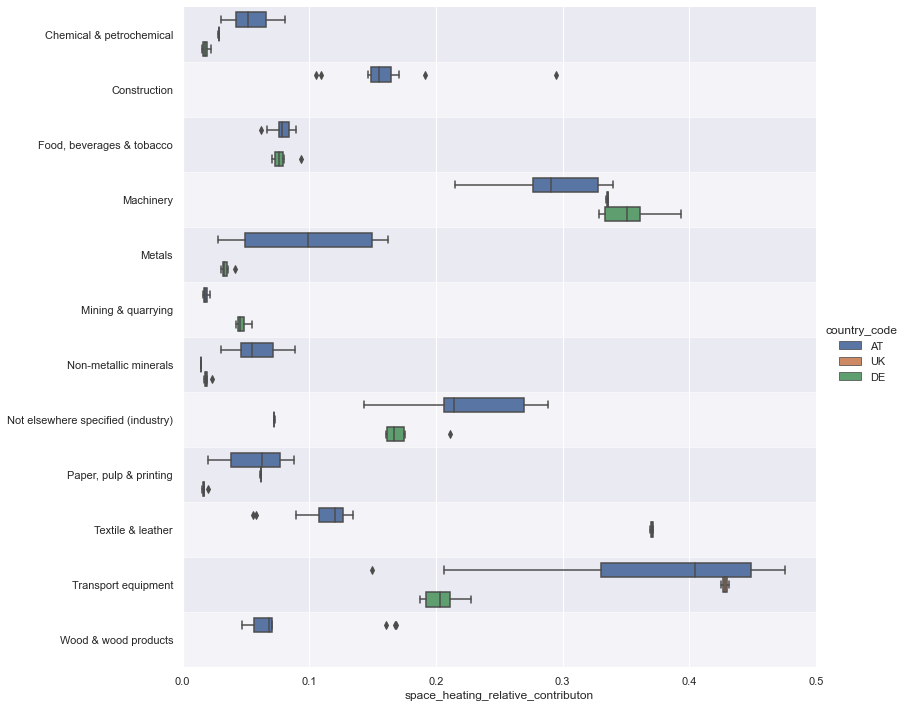

In [1175]:
end_use_sh = (
    end_use_tdf
    .sum(level=['country_code', 'cat_name', 'end_use', 'year'])
    .xs('space_heating', level='end_use')
    .div(end_use_tdf.sum(level=['country_code', 'cat_name', 'year']))
)
end_use_sh.reset_index()
# Plot percentage contribution of heating end uses to total demand for each year, country, and industry subsector
with sns.plotting_context("notebook", font_scale=1):
    g = sns.catplot(
        data=end_use_sh.to_frame('space_heating_relative_contributon').reset_index(), 
        y='cat_name', x='space_heating_relative_contributon', 
        hue="country_code", kind='box',
        hue_order=['AT', 'UK', 'DE'], legend=True, 
        height=10, aspect=1.2
    )
    for i in list(range(12))[::2]:
        g.ax.axvspan(xmin=0, xmax=0.5, ymin=i / 12, ymax=(i + 1) / 12, facecolor='white', alpha=0.5, zorder=-1)
    g.ax.set_xlim(0, 0.5)
    g.ax.set_ylabel('')
    #g.set_titles(col_template = '{col_name}')

In [1176]:
end_use_sh

country_code  cat_name                  year
AT            Chemical & petrochemical  2005    0.081015
                                        2006    0.069801
                                        2007    0.059778
                                        2008    0.051832
                                        2009    0.051889
                                                  ...   
UK            Textile & leather         2017    0.370954
                                        2018    0.369345
              Transport equipment       2016    0.431642
                                        2017    0.428599
                                        2018    0.425227
Length: 237, dtype: float64

In [1163]:
end_use_tdf.sum(level=['country_code', 'cat_name', 'end_use', 'year'])
    .xs('space_heating', level='end_use')
    .div(end_use_tdf.sum(level=['country_code', 'cat_name', 'year']))

0.16666666666666666

[0, 2, 4, 6, 8, 10]

In [1190]:
foo = (    
    industry_energy_balances
    .drop(['Industry sector', 'Non-energy use in industry sector'])
    .mean(level=['cat_code', 'country', 'carrier_code'])
    .unstack()
    .groupby({
        'biofuel': 'non-electricity',
        'district_heat': 'non-electricity',
        'electricity': 'electricity',
        'manufactured_gas': 'non-electricity',
        'natural_gas': 'non-electricity',
        'oil': 'non-electricity',
        'other renewable': 'non-electricity',
        'peat': 'non-electricity',
        'solid_fuel': 'non-electricity',
        'waste': 'non-electricity'
    }, axis=1).sum()
)
foo.div(foo.sum(axis=1), axis=0).stack().reset_index()

,cat_code,country,level_2,0
0,Chemical & petrochemical,ALB,electricity,0.271210
1,Chemical & petrochemical,ALB,non-electricity,0.728790
2,Chemical & petrochemical,AUT,electricity,0.363592
3,Chemical & petrochemical,AUT,non-electricity,0.636408
4,Chemical & petrochemical,BEL,electricity,0.301192
...,...,...,...,...
871,Wood & wood products,SVK,non-electricity,0.711026
872,Wood & wood products,SVN,electricity,0.291446
873,Wood & wood products,SVN,non-electricity,0.708554
874,Wood & wood products,SWE,electricity,0.291826


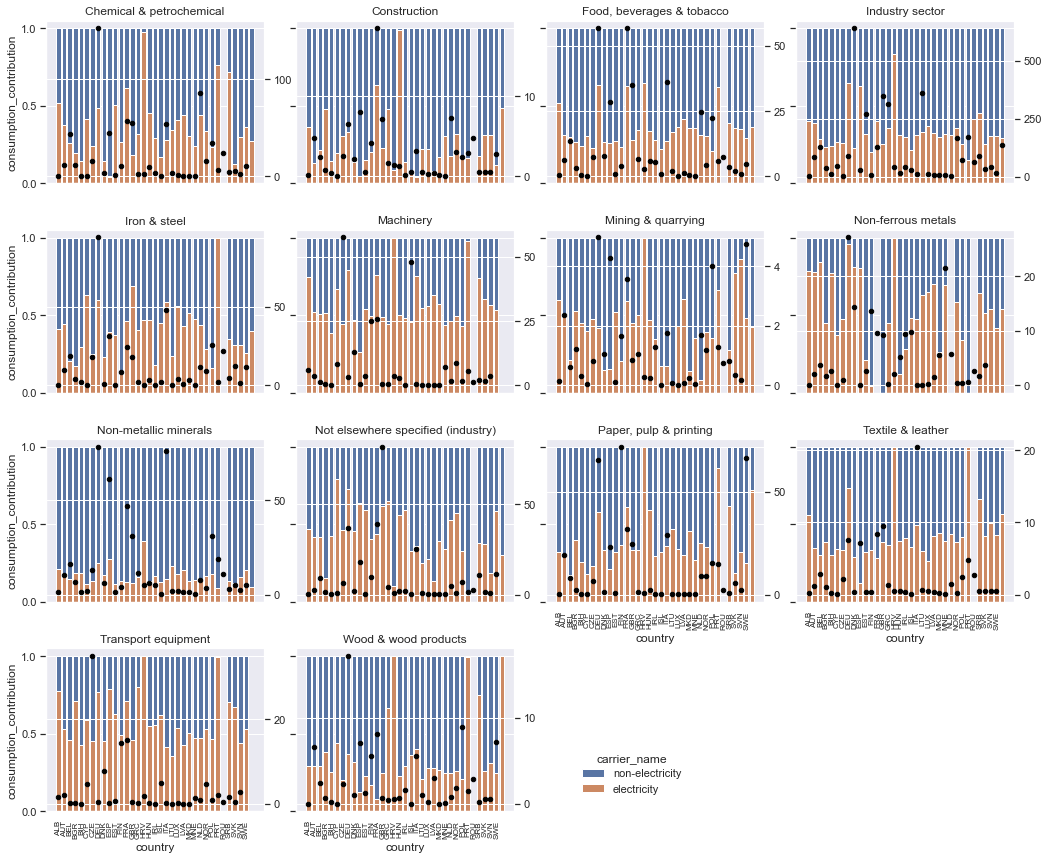

In [1291]:
# Plot percentage contribution of electricity and non-electricity consumption to total energy demand in each industry subsector
# for each country seperately, averaged over all years
electricity_in_industry = (
    industry_energy_balances
    .drop(['Non-energy use in industry sector'])
    .mean(level=['cat_code', 'country', 'carrier_code'])
    .unstack()
    .groupby({
        'biofuel': 'non-electricity',
        'district_heat': 'non-electricity',
        'electricity': 'electricity',
        'manufactured_gas': 'non-electricity',
        'natural_gas': 'non-electricity',
        'oil': 'non-electricity',
        'other renewable': 'non-electricity',
        'peat': 'non-electricity',
        'solid_fuel': 'non-electricity',
        'waste': 'non-electricity'
    }, axis=1).sum()
)
electricity_in_industry = (
    electricity_in_industry
    .stack()
    .to_frame('consumption')
    .merge(electricity_in_industry
           .div(electricity_in_industry.sum(axis=1), axis=0)
           .cumsum(axis=1)
           .stack()
           .to_frame('consumption_contribution'), 
           left_index=True, right_index=True)
)
with sns.plotting_context("notebook", font_scale=1):
    g = sns.FacetGrid(
        electricity_in_industry
        .reset_index()
        .rename(columns={'level_2': 'carrier_name'}), 
        col="cat_code", 
        hue="carrier_name", 
        hue_order=['non-electricity', 'electricity'], 
        col_wrap=4, aspect=1.2
    )
    g.map(
        sns.barplot, 'country', 'consumption_contribution', 
        order=industry_energy_balances.index.levels[1][::-1]
    )
    g.add_legend(loc='center left', bbox_to_anchor=(0.5, 0.1))
    g.set_titles(col_template = '{col_name}')
    foo = [ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center', fontsize=8) for ax in g.axes.flat]
    for ax, (_, subdata) in zip(g.axes, electricity_in_industry.consumption.sum(level=['cat_code', 'country']).reset_index().groupby('cat_code')):
        ax2=ax.twinx()
        subdata.plot.scatter(x='country', y='consumption', ax=ax2, color='black', legend=False)
        ax2.set_ylabel('')

In [1323]:
(electricity_in_industry.consumption.sum(level=['cat_code', 'country']).xs('Industry sector').sort_values() / electricity_in_industry.consumption.sum(level=['cat_code', 'country']).xs('Industry sector').sum()).cumsum()

country
MNE    0.000761
CYP    0.001751
ALB    0.002743
MKD    0.004501
EST    0.006540
LUX    0.008971
LVA    0.011408
BIH    0.014052
LTU    0.017361
ISL    0.021176
HRV    0.025733
SVN    0.030352
IRL    0.038439
DNK    0.046997
SRB    0.055882
BGR    0.066308
HUN    0.077699
SVK    0.089263
GRC    0.101688
CHE    0.114665
PRT    0.132597
NOR    0.153580
AUT    0.177690
CZE    0.203297
ROU    0.229048
BEL    0.265446
FIN    0.302412
SWE    0.341578
NLD    0.390403
POL    0.440338
ESP    0.517932
GBR    0.608875
FRA    0.709430
ITA    0.814426
DEU    1.000000
Name: consumption, dtype: float64

In [1328]:
(electricity_in_industry.consumption.drop('Industry sector').sum(level=['cat_code', 'country']).sum(level=0).sort_values() / electricity_in_industry.xs('Industry sector').consumption.sum()).cumsum()

cat_code
Mining & quarrying                    0.012201
Textile & leather                     0.035190
Wood & wood products                  0.061571
Construction                          0.088243
Transport equipment                   0.118632
Non-ferrous metals                    0.164527
Machinery                             0.233378
Not elsewhere specified (industry)    0.316355
Food, beverages & tobacco             0.420502
Iron & steel                          0.534983
Paper, pulp & printing                0.655488
Non-metallic minerals                 0.794027
Chemical & petrochemical              0.987022
Name: consumption, dtype: float64

In [1329]:
focus_countries = ['CHE', 'PRT', 'NOR', 'AUT', 'CZE', 'ROU', 'BEL', 'FIN', 'SWE', 'NLD', 'POL', 'ESP', 'GBR', 'FRA', 'ITA', 'DEU']   
focus_subsectors = ['Non-ferrous metals', 'Machinery', 'Not elsewhere specified (industry)', 'Food, beverages & tobacco', 'Iron & steel', 'Paper, pulp & printing', 'Non-metallic minerals', 'Chemical & petrochemical']

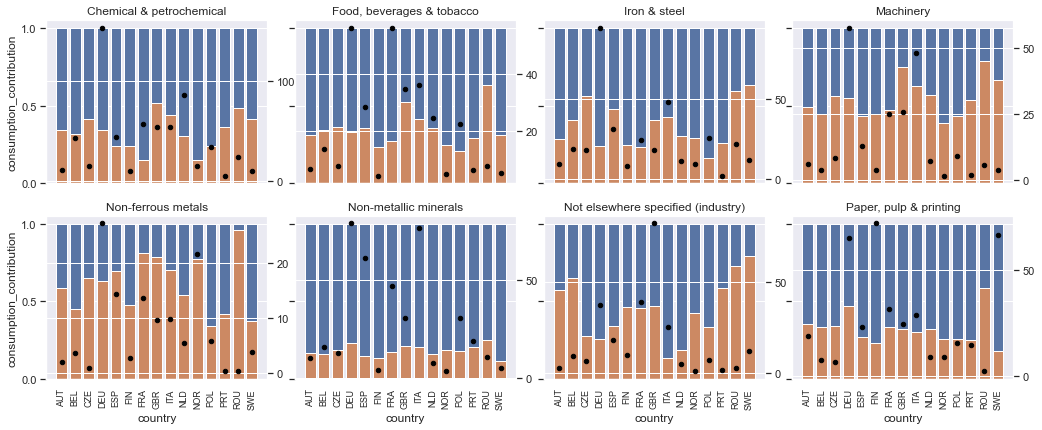

In [1335]:
# Plot percentage contribution of electricity and non-electricity consumption to total energy demand in each industry subsector
# for each country seperately, averaged over all years
with sns.plotting_context("notebook", font_scale=1):
    g = sns.FacetGrid(
        electricity_in_industry.loc[(focus_subsectors, focus_countries), :]
        .reset_index()
        .rename(columns={'level_2': 'carrier_name'}), 
        col="cat_code", 
        hue="carrier_name", 
        hue_order=['non-electricity', 'electricity'], 
        col_wrap=4, aspect=1.2
    )
    g.map(
        sns.barplot, 'country', 'consumption_contribution', 
        order=focus_countries[::-1]
    )
    #g.add_legend(loc='center left', bbox_to_anchor=(0.5, 0.1))
    g.set_titles(col_template = '{col_name}')
    foo = [ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center', fontsize=9) for ax in g.axes.flat]
    for ax, (_, subdata) in zip(g.axes, electricity_in_industry.loc[(focus_subsectors, focus_countries), :].consumption.sum(level=['cat_code', 'country']).reset_index().groupby('cat_code')):
        ax2=ax.twinx()
        subdata.plot.scatter(x='country', y='consumption', ax=ax2, color='black', legend=False)
        ax2.set_ylabel('')

In [1330]:
electricity_in_industry

consumption  \
cat_code                 country                                
Chemical & petrochemical ALB     electricity         0.065320   
                                 non-electricity     0.175527   
                         AUT     electricity         3.992793   
                                 non-electricity     6.988713   
                         BEL     electricity        12.954242   
...                                                       ...   
Wood & wood products     SVK     non-electricity     0.432662   
                         SVN     electricity         0.174783   
                                 non-electricity     0.424927   
                         SWE     electricity         2.083158   
                                 non-electricity     5.055206   

                                                  consumption_contribution  
cat_code                 country                                            
Chemical & petrochemical ALB     electricity                      0.271210  
                                 non-electricity                  1.000000  
                         AUT     electricity                      0.363592  
                                 non-electricity                  1.000000  
                         BEL     electricity                      0.301192  
...                                                                    ...  
Wood & wood products     SVK     non-electricity                  1.000000  
                         SVN     electricity                      0.291446  
                                 non-electricity                  1.000000  
                         SWE     electricity                      0.291826  
                                 non-electricity                  1.000000  

[946 rows x 2 columns]